In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load the dataset
data = pd.read_csv('evaluation.csv', delimiter=';', engine='python', on_bad_lines='skip').head(10000)
data2=pd.read_csv('test (1).csv', delimiter=';', engine='python', on_bad_lines='skip').head(10000)

data = data.drop(columns=['Unnamed: 0'])
data2 = data2.drop(columns=['Unnamed: 0'])

# Preprocess text and labels
texts = data['text'].astype(str)
labels = data['label'].astype(int)

texts2 = data2['text'].astype(str)
labels2 = data2['label'].astype(int)

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

labels2 = label_encoder.fit_transform(labels2)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = tokenizer(self.texts[idx], truncation=True, padding='max_length', max_length=200, return_tensors='pt')
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return encoding['input_ids'].squeeze(), encoding['attention_mask'].squeeze(), label

# Dataloaders
train_dataset = TextDataset(X_train.tolist(), y_train)
test_dataset = TextDataset(X_test.tolist(), y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# LSTM Model
class FakeNewsLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FakeNewsLSTM, self).__init__()
        self.embedding = nn.Embedding(input_dim, 128)
        self.lstm = nn.LSTM(128, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        out = self.dropout(lstm_out[:, -1, :])
        return torch.sigmoid(self.fc(out))

# Model instantiation
model = FakeNewsLSTM(30522, 64, 1).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(7):
    model.train()
    for input_ids, attention_mask, labels in train_loader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device).float()
        optimizer.zero_grad()
        outputs = model(input_ids).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

# Evaluation
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for input_ids, attention_mask, labels in test_loader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device).float()
        outputs = model(input_ids).squeeze()
        predicted = (outputs > 0.5).long()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')


Using device: cuda
Epoch 1, Loss: 0.6553
Epoch 2, Loss: 0.6451
Epoch 3, Loss: 0.6087
Epoch 4, Loss: 0.7132
Epoch 5, Loss: 0.4351
Epoch 6, Loss: 0.2786
Epoch 7, Loss: 0.3789
Accuracy: 92.43%


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer
import joblib

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load the datasets
data = pd.read_csv('train.csv', delimiter=';', engine='python', on_bad_lines='skip').head(10000)
data2 = pd.read_csv('test (1).csv', delimiter=';', engine='python', on_bad_lines='skip').head(10000)

# Drop unnecessary columns
data = data.drop(columns=['Unnamed: 0'])
data2 = data2.drop(columns=['Unnamed: 0'])

# Preprocess text and labels
texts = data['text'].astype(str)
labels = data['label'].astype(int)

texts2 = data2['text'].astype(str)
labels2 = data2['label'].astype(int)

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
labels2 = label_encoder.transform(labels2)  # Use transform to ensure same encoding

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Custom Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = tokenizer(self.texts[idx], truncation=True, padding='max_length', max_length=200, return_tensors='pt')
        label = torch.tensor(self.labels[idx], dtype=torch.float)
        return encoding['input_ids'].squeeze(), encoding['attention_mask'].squeeze(), label

# Dataloaders
train_dataset = TextDataset(texts.tolist(), labels)
test_dataset = TextDataset(texts2.tolist(), labels2)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# LSTM Model
class FakeNewsLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FakeNewsLSTM, self).__init__()
        self.embedding = nn.Embedding(input_dim, 128)
        self.lstm = nn.LSTM(128, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        out = self.dropout(lstm_out[:, -1, :])
        return torch.sigmoid(self.fc(out))

# Model instantiation
model = FakeNewsLSTM(30522, 64, 1).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(10):
    model.train()
    total_loss = 0
    for input_ids, attention_mask, labels in train_loader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Average Loss: {total_loss / len(train_loader):.4f}')

# Evaluation on full test set
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for input_ids, attention_mask, labels in test_loader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids).squeeze()
        predicted = (outputs > 0.5).long()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

torch.save(model.state_dict(), 'model.pth')

print(f'Final Test Accuracy: {100 * correct / total:.2f}%')


Using device: cuda
Epoch 1, Average Loss: 0.6471
Epoch 2, Average Loss: 0.4626
Epoch 3, Average Loss: 0.4157
Epoch 4, Average Loss: 0.3278
Epoch 5, Average Loss: 0.3229
Epoch 6, Average Loss: 0.2909
Epoch 7, Average Loss: 0.2631
Epoch 8, Average Loss: 0.1926
Epoch 9, Average Loss: 0.1718
Epoch 10, Average Loss: 0.1501
Final Test Accuracy: 93.77%


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer
import joblib

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load the datasets
data = pd.read_csv('train.csv', delimiter=';', engine='python', on_bad_lines='skip').head(10000)
data2 = pd.read_csv('test (1).csv', delimiter=';', engine='python', on_bad_lines='skip').head(10000)

# Drop unnecessary columns
data = data.drop(columns=['Unnamed: 0'])
data2 = data2.drop(columns=['Unnamed: 0'])

# Preprocess text and labels
texts = data['text'].astype(str)
labels = data['label'].astype(int)

texts2 = data2['text'].astype(str)
labels2 = data2['label'].astype(int)

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
labels2 = label_encoder.transform(labels2)  # Use transform to ensure same encoding

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Custom Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = tokenizer(self.texts[idx], truncation=True, padding='max_length', max_length=200, return_tensors='pt')
        label = torch.tensor(self.labels[idx], dtype=torch.float)
        return encoding['input_ids'].squeeze(), encoding['attention_mask'].squeeze(), label

# Dataloaders
train_dataset = TextDataset(texts.tolist(), labels)
test_dataset = TextDataset(texts2.tolist(), labels2)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# LSTM Model
class FakeNewsLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FakeNewsLSTM, self).__init__()
        self.embedding = nn.Embedding(input_dim, 128)
        self.lstm = nn.LSTM(128, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        out = self.dropout(lstm_out[:, -1, :])
        return torch.sigmoid(self.fc(out))

# Model instantiation
model = FakeNewsLSTM(30522, 64, 1).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(20):
    model.train()
    total_loss = 0
    for input_ids, attention_mask, labels in train_loader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Average Loss: {total_loss / len(train_loader):.4f}')

# Evaluation on full test set
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for input_ids, attention_mask, labels in test_loader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids).squeeze()
        predicted = (outputs > 0.5).long()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

torch.save(model.state_dict(), 'model.pth')

print(f'Final Test Accuracy: {100 * correct / total:.2f}%')


Using device: cuda
Epoch 1, Average Loss: 0.6611
Epoch 2, Average Loss: 0.5633
Epoch 3, Average Loss: 0.6176
Epoch 4, Average Loss: 0.5402
Epoch 5, Average Loss: 0.6765
Epoch 6, Average Loss: 0.4738
Epoch 7, Average Loss: 0.2224
Epoch 8, Average Loss: 0.1208
Epoch 9, Average Loss: 0.1038
Epoch 10, Average Loss: 0.1029
Epoch 11, Average Loss: 0.0831
Epoch 12, Average Loss: 0.0729
Epoch 13, Average Loss: 0.0542
Epoch 14, Average Loss: 0.0389
Epoch 15, Average Loss: 0.0290
Epoch 16, Average Loss: 0.0158
Epoch 17, Average Loss: 0.0099
Epoch 18, Average Loss: 0.0061
Epoch 19, Average Loss: 0.0060
Epoch 20, Average Loss: 0.0040
Final Test Accuracy: 98.53%


In [11]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer

In [12]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load the datasets
data = pd.read_csv('train.csv', delimiter=';', engine='python', on_bad_lines='skip')
data2 = pd.read_csv('test (1).csv', delimiter=';', engine='python', on_bad_lines='skip')

Using device: cuda


In [13]:
# Drop unnecessary columns
data = data.drop(columns=['Unnamed: 0'])
data2 = data2.drop(columns=['Unnamed: 0'])

# Preprocess text and labels
texts = data['text'].astype(str)
labels = data['label'].astype(int)
texts2 = data2['text'].astype(str)
labels2 = data2['label'].astype(int)

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
labels2 = label_encoder.transform(labels2)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [14]:
# Custom Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = tokenizer(self.texts[idx], truncation=True, padding='max_length', max_length=200, return_tensors='pt')
        label = torch.tensor(self.labels[idx], dtype=torch.float)
        return encoding['input_ids'].squeeze(), encoding['attention_mask'].squeeze(), label


# Split training data into train and validation
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts.tolist(), labels, test_size=0.1, random_state=42
)

train_dataset = TextDataset(train_texts, train_labels)
val_dataset = TextDataset(val_texts, val_labels)
test_dataset = TextDataset(texts2.tolist(), labels2)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [15]:
# LSTM Model
class FakeNewsLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FakeNewsLSTM, self).__init__()
        self.embedding = nn.Embedding(input_dim, 128)
        self.lstm = nn.LSTM(128, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        out = self.dropout(lstm_out[:, -1, :])
        return torch.sigmoid(self.fc(out))

# Model instantiation
model = FakeNewsLSTM(30522, 64, 1).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping parameters
patience = 3
best_val_loss = float('inf')
patience_counter = 0

# Training loop with early stopping
for epoch in range(50):
    model.train()
    total_loss = 0
    for input_ids, attention_mask, labels in train_loader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for input_ids, attention_mask, labels in val_loader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Final evaluation on test set
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for input_ids, attention_mask, labels in test_loader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids).squeeze()
        predicted = (outputs > 0.5).long()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Final Test Accuracy: {100 * correct / total:.2f}%')


Epoch 1, Train Loss: 0.5858, Val Loss: 0.4402
Epoch 2, Train Loss: 0.4235, Val Loss: 0.3258
Epoch 3, Train Loss: 0.4445, Val Loss: 0.4765
Epoch 4, Train Loss: 0.3712, Val Loss: 0.2756
Epoch 5, Train Loss: 0.3598, Val Loss: 0.4268
Epoch 6, Train Loss: 0.3675, Val Loss: 0.3049
Epoch 7, Train Loss: 0.2822, Val Loss: 0.1468
Epoch 8, Train Loss: 0.0953, Val Loss: 0.1055
Epoch 9, Train Loss: 0.0794, Val Loss: 0.1334
Epoch 10, Train Loss: 0.0866, Val Loss: 0.1094
Epoch 11, Train Loss: 0.0694, Val Loss: 0.1239
Early stopping triggered at epoch 11
Final Test Accuracy: 98.10%


In [16]:
torch.save(model.state_dict(), 'LSTM.pth')

In [17]:
joblib.dump(label_encoder, 'label_encoder.joblib')

['label_encoder.joblib']

In [20]:
tokenizer.save_pretrained('./tokenizer')

print("All files saved successfully.")

from google.colab import files
import shutil
'''
# Download the model file
files.download('best_model.pth')

# Download the label encoder
files.download('label_encoder.joblib')'''

# Zip the tokenizer folder before downloading
shutil.make_archive('tokenizer', 'zip', 'tokenizer')

# Download the zipped tokenizer folder
files.download('tokenizer.zip')


All files saved successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

model.load_state_dict(torch.load('best_model.pth'))
model.to(device)
model.eval()

all_labels = []
all_probs = []

with torch.no_grad():
    for input_ids, attention_mask, labels in test_loader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids).squeeze()  # probabilities between 0 and 1
        all_probs.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert probabilities to class predictions
preds = [1 if p > 0.5 else 0 for p in all_probs]

# Calculate and print metrics
print(f'Precision: {precision_score(all_labels, preds):.4f}')
print(f'Recall: {recall_score(all_labels, preds):.4f}')


Precision: 0.9946
Recall: 0.9700


In [23]:
print(f'F1 Score: {f1_score(all_labels, preds):.4f}')

F1 Score: 0.9821


In [24]:
print(f'ROC AUC: {roc_auc_score(all_labels, all_probs):.4f}')
print(f'Average Precision (AP): {average_precision_score(all_labels, all_probs):.4f}')

ROC AUC: 0.9912
Average Precision (AP): 0.9944


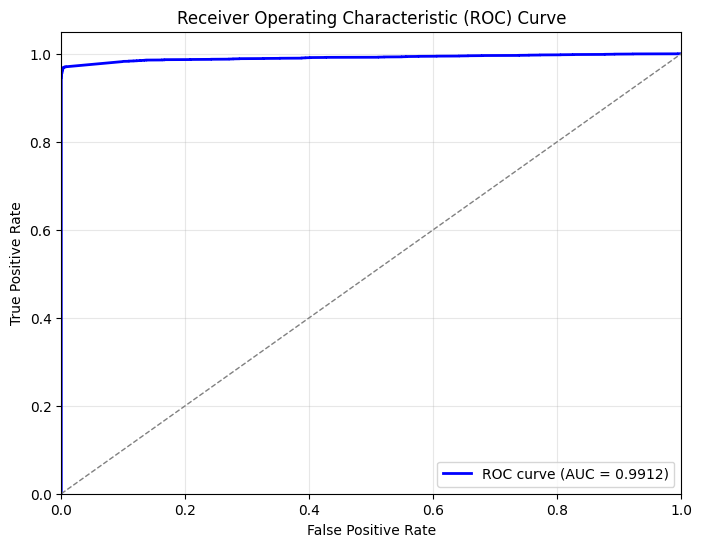

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have all_labels and all_probs from your test set

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()
